In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tabulate import tabulate
import seaborn as sns
import scikitplot as skplt
from numpy import percentile
import math


#pandas
from pandas.plotting import parallel_coordinates
from datetime import date, datetime

#sklearn
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import learning_curve

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix
#scikitplot
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from scikitplot.metrics import plot_lift_curve
from scikitplot.metrics import plot_cumulative_gain
import scikitplot 
#mlxtend
from mlxtend.plotting import plot_decision_regions

#matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import pyplot

#seaborn
import seaborn as sns
#scipy
import scipy.stats as stats
from scipy.stats import shapiro, mannwhitneyu, normaltest, kstest
from scipy.stats import boxcox, yeojohnson
from pyod.models.knn import KNN

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler

# Data Preparation

In [2]:
X_train = pd.read_csv('Dataset/train/Inertial Signals/body_acc_x_train.txt', header=None, delim_whitespace=True)
#X_train['subject'] = pd.read_csv('Dataset/train/subject_train.txt', header=None)
y_train = pd.read_csv('Dataset/train/y_train.txt', header = None, names = ['Activity'])

y_train.loc[y_train.Activity <4, 'Activity'] = 1 #1,2,3 Dinamiche
y_train.loc[y_train.Activity >3, 'Activity'] = 0 #4,5,6 Statiche
print(f"Number of time series: {X_train.shape[0]}\nLength: {X_train.shape[1]}")


Number of time series: 7352
Length: 128


In [3]:
X_test = pd.read_csv('Dataset/test/Inertial Signals/body_acc_x_test.txt', header=None, delim_whitespace=True)
#X_train['subject'] = pd.read_csv('Dataset/train/subject_train.txt', header=None)
y_test = pd.read_csv('Dataset/test/y_test.txt', header = None, names = ['Activity'])

y_test.loc[y_test.Activity <4, 'Activity'] = 1 #1,2,3 Dinamiche
y_test.loc[y_test.Activity >3, 'Activity'] = 0 #4,5,6 Statiche
print(f"Number of time series: {X_test.shape[0]}\nLength: {X_test.shape[1]}")


Number of time series: 2947
Length: 128


# Preprocessing

In [8]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X_train = scaler.fit_transform(X_train)
X_train = X_train.squeeze()

In [9]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
scaler = TimeSeriesScalerMeanVariance(mu=0., std=1.)  # Rescale time series
X_test = scaler.fit_transform(X_test)
X_test = X_test.squeeze()

In [10]:
from pyts.classification import KNeighborsClassifier

# Parametri globali

In [11]:
# Parametri globali ##----AGGIUNTI DOPO-----##

n_iter = 10
scoring = 'f1_weighted'
random_state = 42

# test_n_splits = 9
test_n_splits = 3

model = KNeighborsClassifier()
model_name = "KNeighborsClassifier"

v_or_t_flag = "TST"
cmap = plt.cm.Blues
color = "blue"

# KNN baseline

In [37]:
def model_baseline_classification(X_tr, y_tr, X_ts, y_ts):
    fitted_model = model.fit(X_tr, y_tr.values.ravel())
    y_pred = model.predict(X_ts)
    
    print(confusion_matrix(y_ts, y_pred))
    print(classification_report(y_ts, y_pred))

    
    
    

In [38]:
model_baseline_classification(X_train, 
                              y_train, 
                              X_test, 
                              y_test)

[[1413  147]
 [   0 1387]]
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1560
           1       0.90      1.00      0.95      1387

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



# Funzioni da utilizzare

In [12]:
# PLOT FUNCTIONS
def plot_roc_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_roc(y_ts, y_prob)
    plt.title("%s\'s %s ROC curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_precision_recall_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_precision_recall(y_ts, y_prob)
    plt.title("%s\'s %s Precision-Recall curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_cumulative_gain_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_cumulative_gain(y_ts, y_prob)
    plt.title("%s\'s %s Cumulative Gains curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_lift_curve_curve(y_ts, y_prob):
    plt.figure(figsize=(8, 5))
    plot_lift_curve(y_ts, y_prob)
    plt.title("%s\'s %s Lift curve" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_confusion_matrix(cm, classes, normalize):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("%s\'s %s classification report" % (model_name, v_or_t_flag.upper()))
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def plot_classification_report(y_ts, y_pred):
    model_report = classification_report(y_ts, 
                                       y_pred,
                                       # target_names=['Studio Recording', 'Live Recording'],
                                       output_dict=True)
    model_r = pd.DataFrame(model_report).iloc[:-1, :].T
    sns.heatmap(model_r, annot=True, cmap=cmap, cbar=False)
    plt.title("%s\'s %s confusion matrix" % (model_name, v_or_t_flag.upper()))
    plt.show()
    
def plot_decision_boundary(X_tr, y_tr, scaler, model):
    try:
        pca = PCA(n_components=2)
        best_visualisation_scaler = StandardScaler()
        scaled_X_tr = best_visualisation_scaler.fit_transform(X_tr)
        X = pca.fit_transform(scaled_X_tr)
        # X = pca.fit_transform(X_tr)
        y = y_tr.values.ravel()

        model.fit(X, y)
        plt.figure(figsize=(8, 5))
        fig = plot_decision_regions(X=X, y=y, clf=model, legend=2)
        plt.xlabel("PCA component 1")
        plt.ylabel("PCA component 2")
        plt.title("%s's %s decision boundary" % (model_name, v_or_t_flag))
        plt.legend(loc='best')
        plt.grid(False)
        plt.show()
    except ValueError:
        return
    
    
def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                                       n_jobs=-1, random_state=random_state)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 

def get_tuned_model(X_tr, y_tr, params):
    
    X_tr_curr = X_tr.copy()
    
    model_params = list(model_grid(X_tr_curr).keys())
    try:
        n_bins = params['preprocessor__numeric__discretizer__n_bins'] 
        strategy = params['preprocessor__numeric__discretizer__strategy']
        encode = params['preprocessor__numeric__discretizer__encode']
        discretizer = KBinsDiscretizer(encode=encode, n_bins=n_bins, strategy=strategy)
        # scale data
        X_tr_curr = discretizer.fit_transform(X_tr_curr.values)
    except KeyError:
        pass

    try:
        scaler = params['preprocessor__numeric__discretizer__scaler']
        # scale data
        X_tr_curr = scaler.fit_transform(X_tr_curr.values)
    except KeyError:
        pass
    
    # retrieve best hyperameters
    tmp_model_hyperparameters = dict((k, params[k]) for k in model_params if k in params)
    model_hyperparameters = {}
    for key, value in tmp_model_hyperparameters.items():
        key = key.split('model__')[1].replace("'", "")
        model_hyperparameters[key] = value
        
    tuned_model =  model.set_params(**model_hyperparameters)
    tuned_model.fit(X_tr_curr, y_tr.values.ravel())
    
    plot_decision_boundary(X_tr_curr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    
    #if learning_curve_flag:
        #plot_learning_curve(curr_X_tr_vt, y_tr, tuned_model, v_or_t_flag)
    
    return tuned_model

from yellowbrick.model_selection import LearningCurve

def plot_learning_curve(X_tr, y_tr, model, v_or_t_flag):
    second_score = ""
    if v_or_t_flag == 'VAL':
        cv = StratifiedKFold(n_splits=validation_n_splits)
        second_score = "Validation score"
    else:
        cv = StratifiedKFold(n_splits=test_n_splits)
        second_score = "Test score"
        
    my_title = model_name + "'s %s Learning Curve" % (v_or_t_flag) 
        
    sizes = np.linspace(0.3, 1.0, 10)
    plt.figure(figsize=(8, 5))
    visualizer = LearningCurve(model, cv=cv, scoring=scoring, train_sizes=sizes, 
                                                        n_jobs=-1, random_state=random_state, title=my_title)

    visualizer.fit(X_tr, y_tr.values.ravel())    
    # visualizer.ax.get_lines()[1].set_label(second_score)
    visualizer.show() 
    
def grid_search(X_tr, y_tr, X_ts, y_ts, numeric_features, categorical_features, discretizer_flag, 
                                                            scaler_flag, feature_filter_key, feature_flag):
    
    # define the evaluation method
    cv = StratifiedKFold(n_splits=test_n_splits)

    # construct the pipeline to evaluate
    grid=model_grid(X_tr)
    steps = [('model', model)]
        
    # construct feature type's column transformer
    numeric_steps = []
    if scaler_flag:      # continous variable normalisation/standardisation
        numeric_steps.insert(0, ('scaler', None))
        grid['preprocessor__numeric__scaler'] = [MinMaxScaler(), MaxAbsScaler(), StandardScaler(), RobustScaler()]
                      
    numeric_transformer = None
    if len(numeric_steps) > 0:
        numeric_transformer = Pipeline(steps=numeric_steps)
        preprocessor = ColumnTransformer(
        transformers=[('numeric', numeric_transformer, numeric_features)])
        # add numeric ColumnTransformer to global Pipeline
        steps.insert(0, ('preprocessor', preprocessor))
        
    # define the pipeline to evaluate
    pipeline = Pipeline(steps=steps)
    
    # define the grid search
    # search = GridSearchCV(pipeline, grid, scoring='f1_weighted', n_jobs=-1, cv=cv, verbose=2)
    search = RandomizedSearchCV(pipeline, grid, scoring=scoring, n_jobs=-1, 
                                n_iter=n_iter, cv=cv, verbose=2, refit=scoring, random_state=random_state)
    
    # perform the search
    results = search.fit(X_tr, y_tr.values.ravel())
    
    # summarize best
    score = results.best_score_
    params = results.best_params_
    print('Best Mean F1_weighted: %.3f ' % score)
    print('Best Config: %s ' % params)
    
    # perform classification (linear model doesn't predict an integer value => no predict_proba)
    y_pred = search.predict(X_ts)
    y_prob = y_pred
    
    
    # retrieve the tuned model
    tuned_model = get_tuned_model(X_tr, y_tr, params)
    if tuned_model !=  pipeline['model']:
        print("Difference in tuned model and pipeline")
        print("tuned_model", tuned_model)
        print("pipe", pipeline['model'])
        # print("estimator", results.estimator)
        sys.exit(-1)
        

    #print("roc", roc_auc_score(y_ts.values.ravel(), y_pred, average="weighted"))
    #sklearn.metrics.plot_roc_curve(results, X_ts, y_ts.values.ravel())     
    #skplt.metrics.plot_roc(y_ts, y_prob1)
   
    plt.show()
    
    # plots
    
    
    cm = confusion_matrix(y_ts, y_pred.round())
    plot_confusion_matrix(cm, [1,2], True)
    plot_classification_report(y_ts.values.ravel(), y_pred)
    
    """plot_roc_curve(y_ts, y_prob)
    plot_precision_recall_curve(y_ts, y_prob)
    plot_cumulative_gain_curve(y_ts, y_prob)
    plot_lift_curve_curve(y_ts, y_prob)"""
    
    # plot_decision_boundary(X_tr, y_tr, MinMaxScaler(), tuned_model)  # passing random scaler
    # plot_learning_curve(X_tr, y_tr, tuned_model)
    # error_visualizer(not_scale_X_ts, y_ts, y_pred, 'chroma_cens_02', 'track_duration')
    
    return params, tuned_model, y_pred, y_prob

# KNN metric = euclidean 

In [17]:
import itertools

In [41]:
sqrt_records = round(math.sqrt(X_train.shape[1]))
k_range = list(range(2, sqrt_records+1, 2)) #setting k= square root of 561 = 24

def model_grid(X_tr):
    grid = dict()
    grid['model__n_neighbors'] = k_range
    grid['model__weights'] = ['uniform', 'distance']
    grid['model__metric'] = ['euclidean']
    return grid

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.959 
Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 2, 'model__metric': 'euclidean'} 


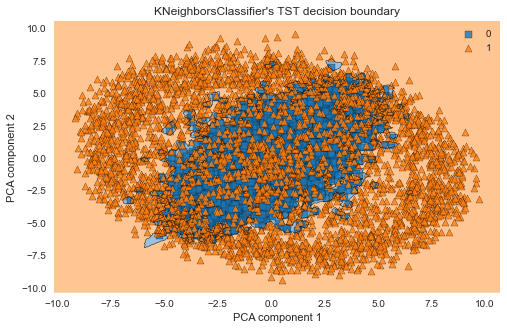

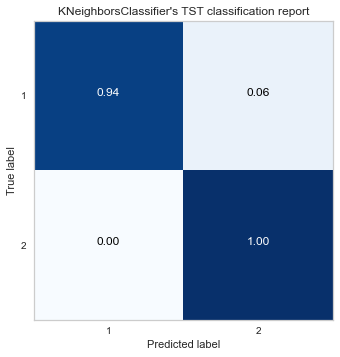

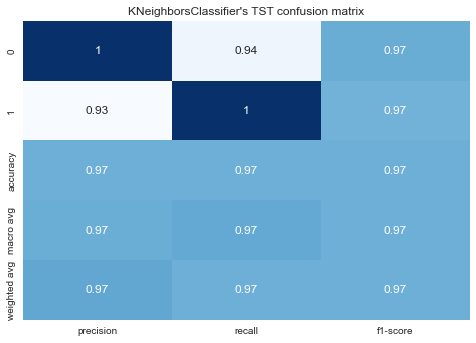

In [42]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst = \
                                                    grid_search(X_tr=X_train, 
                                                                y_tr=y_train,
                                                                X_ts=X_test, 
                                                                y_ts=y_test,
                                                                numeric_features=X_train, 
                                                                categorical_features=X_train, 
                                                                discretizer_flag=False,
                                                                scaler_flag=False, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv

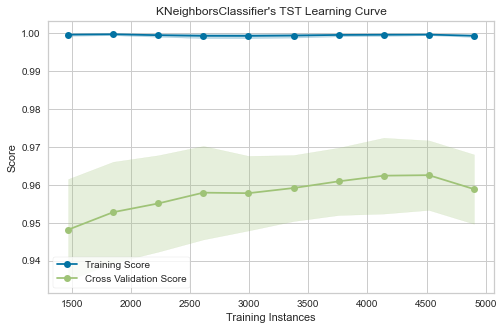

In [43]:
v_or_t_flag = "TST"
plot_learning_curve(X_train, 
                    y_train, 
                    tuned_model_tst, 
                    v_or_t_flag)

# KNN metric = manhattan 

In [44]:
import itertools

In [45]:
sqrt_records = round(math.sqrt(X_train.shape[1]))
k_range = list(range(2, sqrt_records+1, 2)) #setting k= square root of 561 = 24

def model_grid(X_tr):
    grid = dict()
    grid['model__n_neighbors'] = k_range
    grid['model__weights'] = ['uniform', 'distance']
    grid['model__metric'] = ['manhattan']
    return grid

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.968 
Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 2, 'model__metric': 'manhattan'} 


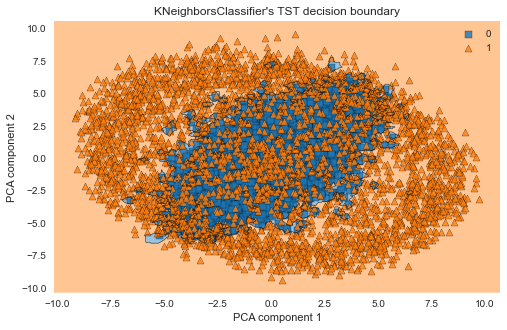

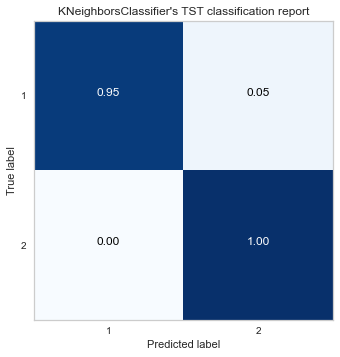

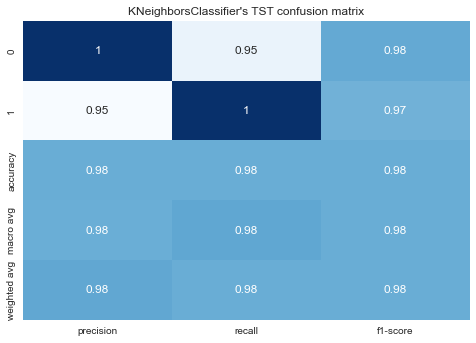

In [46]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst = \
                                                    grid_search(X_tr=X_train, 
                                                                y_tr=y_train,
                                                                X_ts=X_test, 
                                                                y_ts=y_test,
                                                                numeric_features=X_train, 
                                                                categorical_features=X_train, 
                                                                discretizer_flag=False,
                                                                scaler_flag=False, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv

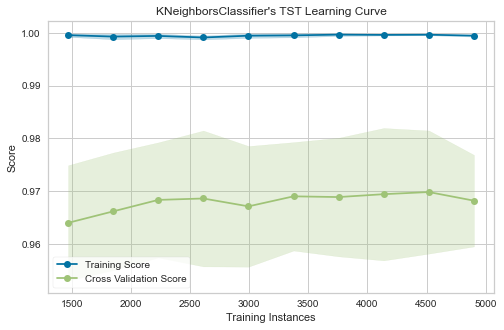

In [47]:
v_or_t_flag = "TST"
plot_learning_curve(X_train, 
                    y_train, 
                    tuned_model_tst, 
                    v_or_t_flag)

# KNN metric = DTW 

In [4]:
X_train = X_train.loc[:200]
y_train = y_train.loc[:200]


In [5]:
X_test = X_test.loc[:100]
y_test = y_test.loc[:100]

In [16]:
import itertools

In [20]:
sqrt_records = round(math.sqrt(X_train.shape[1]))
k_range = list(range(2, sqrt_records+1, 2)) #setting k= square root of 561 = 24

def model_grid(X_tr):
    grid = dict()
    grid['model__n_neighbors'] = k_range
    grid['model__weights'] = ['uniform', 'distance']
    grid['model__metric'] = ['dtw_fast']
    return grid

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Mean F1_weighted: 0.875 
Best Config: {'model__weights': 'uniform', 'model__n_neighbors': 2, 'model__metric': 'dtw_fast'} 


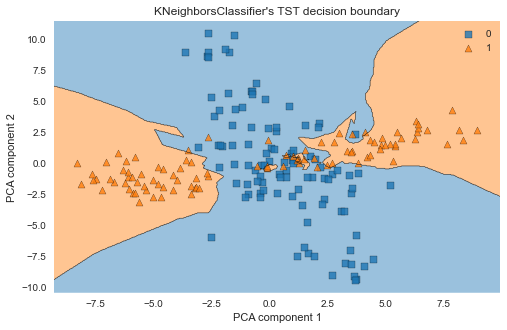

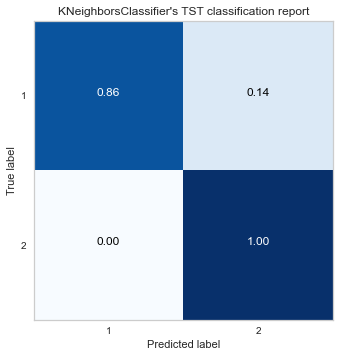

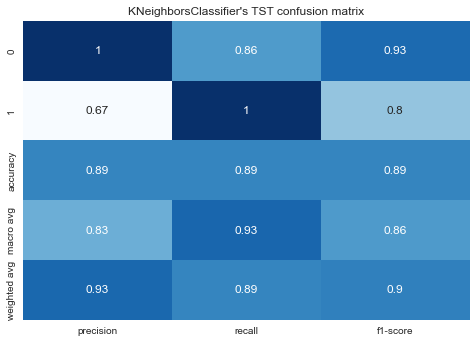

In [21]:
params_tst, tuned_model_tst, y_pred_tst, y_prob_tst = \
                                                    grid_search(X_tr=X_train, 
                                                                y_tr=y_train,
                                                                X_ts=X_test, 
                                                                y_ts=y_test,
                                                                numeric_features=X_train, 
                                                                categorical_features=X_train, 
                                                                discretizer_flag=False,
                                                                scaler_flag=False, 
                                                                feature_filter_key="", 
                                                                feature_flag=False)

dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv', 'estimator', 'exploit_incremental_learning', 'groups', 'n_jobs', 'pre_dispatch', 'random_state', 'scoring', 'shuffle', 'train_sizes', 'algorithm', 'leaf_size', 'metric', 'metric_params', 'n_neighbors', 'p', 'weights']) 


dict_keys(['ax', 'cv

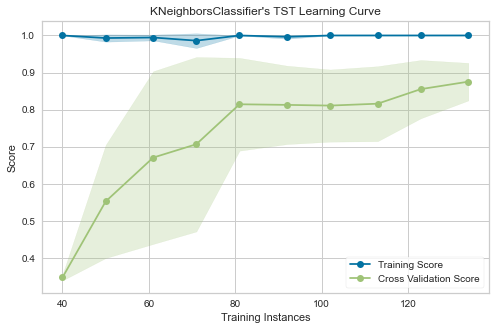

In [22]:
v_or_t_flag = "TST"
plot_learning_curve(X_train, 
                    y_train, 
                    tuned_model_tst, 
                    v_or_t_flag)

### senza gridsearch (non importante)